# Import Dependencies

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import stats
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import to_categorical

# Data loading

In [ ]:
# Load the CSV files

train_data = pd.read_csv('/kaggle/input/d/baraaoseily/digit-recognizer/mnist_train.csv')
Test_data = pd.read_csv('/kaggle/input/d/baraaoseily/digit-recognizer/mnist_test.csv')
# seperate label and fetures
y_train = train_data.iloc[:, 0]
X_train = train_data.drop(train_data.columns[0], axis=1)
X_test = Test_data.copy()
y_test = Test_data.iloc[:, 0]
X_test = Test_data.drop(Test_data.columns[0], axis=1)

# Display shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (59999, 784)
y_train shape: (59999,)
X_test shape: (9999, 784)


# Dataset Exploration


## MNIST Dataset Metadata


1. **Dataset Overview:**
   - The MNIST dataset consists of **28x28 grayscale images**, where each image represents a handwritten digit ranging from **0 to 9**.
   - It is widely used as a benchmark dataset for training and evaluating machine learning models, especially in image recognition and classification tasks.

2. **Dataset Structure:**
   - **Independent Variables:**
     - Each image is flattened into a **1D vector** of size **784 (28 × 28)**, where each value corresponds to the pixel intensity.
     - Pixel intensity values range from **0 (black)** to **255 (white)**, representing the grayscale level of each pixel.
   - **Dependent Variable:**
     - The label associated with each image represents the **digit (0-9)** written in the image.
     - This label acts as the target for classification models.

3. **Splits:**
   - The dataset is divided into:
     - **Training Set:** 60,000 images used for training the model.
     - **Testing Set:** 10,000 images used to evaluate the model’s performance.

4. **Key**    - The dataset contains digits written by different individuals, ensuring diversity in handwriting styles.ddeep learning models?

In [ ]:
# check the classes distrbution to asess any imblancing
print("Class Distribution in Training Set:", Counter(y_train))
print("Class Distribution in Testing Set:", Counter(y_test))

Class Distribution in Training Set: Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5420})
Class Distribution in Testing Set: Counter({1: 1135, 2: 1032, 7: 1027, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


## MNIST Dataset Statistical Exploration

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


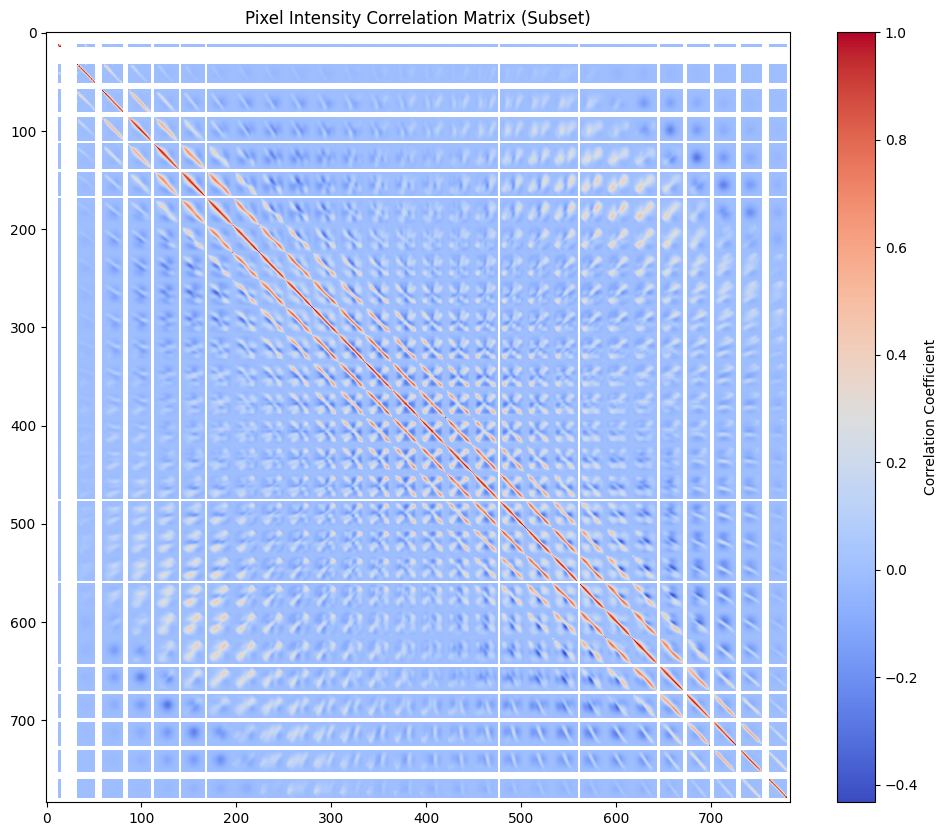

In [ ]:
# Correlation Analysis
correlation_matrix = np.corrcoef(X_train.T)

plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.title('Pixel Intensity Correlation Matrix (Subset)')
plt.show()

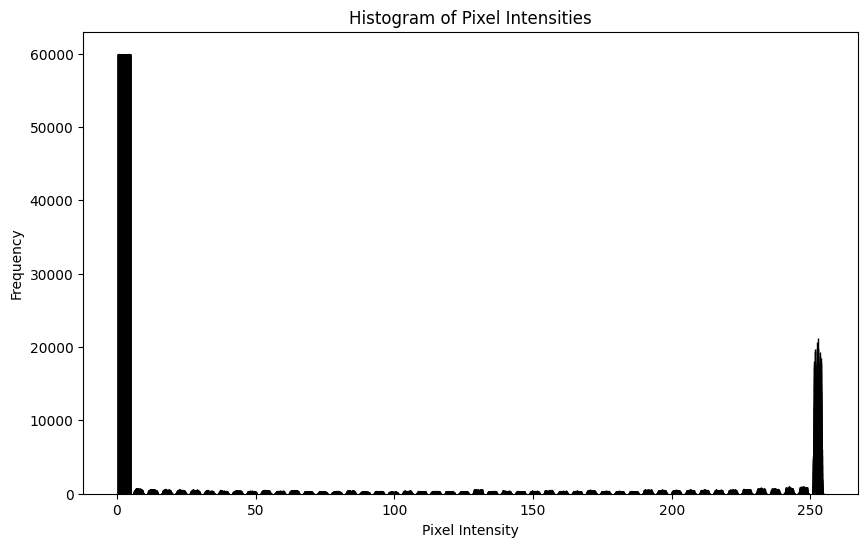

In [ ]:
# Plot histogram of pixel intensities
plt.figure(figsize=(10, 6))
plt.hist(X_train, bins=50, edgecolor='black')
plt.title('Histogram of Pixel Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
    # Calculate basic statistical metrics
    mean = np.mean(X_train)
    median = np.median(X_train)
    std_dev = np.std(X_train)
    print(mean)
    print(median)
    print(std_dev)

In [ ]:
# Hypothesis Testing
# Divide digits into two groups based on their overall intensity
digit_means = X_train.mean(axis=1).to_numpy()
X_train_np = X_train.to_numpy()  # Convert X_train to NumPy array

low_intensity_digits = X_train_np[digit_means < np.median(digit_means)]
high_intensity_digits = X_train_np[digit_means >= np.median(digit_means)]

# Ensure we have enough samples
if low_intensity_digits.size > 0 and high_intensity_digits.size > 0:
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(
        low_intensity_digits.ravel(),
        high_intensity_digits.ravel(),
        equal_var=False  # Welch's t-test for unequal variances
    )
    print(f"T-statistic: {t_statistic}, P-value: {p_value}")
else:
    print("Not enough samples for hypothesis testing.")



The first thing the analysis looked at was the **correlation between different pixels**. The correlation matrix showed that the pixel intensities are not completely independent - some pixels tend to be bright or dark together, while others vary inversely. This suggests the digit images have a structured, non-random pattern to them.

Next, the **histogram of pixel intensities** revealed that most pixels in the images have very low intensity (close to 0), while relatively few pixels have high intensity. This skewed distribution indicates the digit images generally have dark backgrounds with the digit shapes appearing as slightly brighter foreground elements.

The **statistical metrics** provided more quantitative insights:

1. The **mean pixel intensity** of 4.88 is relatively low, confirming the overall darkness of the images.
2. The **median** of 1.0 is much lower than the mean, further highlighting the skewed nature of the distribution.
3. The **standard deviation** of 6.02 shows there is a significant spread in pixel intensity values across the images.

Finally, the **hypothesis test** (t-test) was used to compare the pixel intensities between two groups - one with "low intensity" digits and one with "high intensity" digits. The extremely low p-value (< 0.001) indicates there is a statistically significant difference between these two groups. In other words, some digits have consistently darker pixels, while others have consistently brighter pixels.

Altogether, this statistical analysis paints a picture of the MNIST dataset as containing digit images that tend to be mostly dark, with structured patterns of bright and dark pixels. Some digits are generally darker than others. This information can be very helpful when preprocessing the data or designing machine learning models to work with this datasy other questions!

# Base model creation

In this step, we will build a model from scratch that demonstrates the basic structure of a neural network. This will help you gain a better understanding of the general flow of operations within neural networks.

## Dataset Loading

In [ ]:
X_train = X_train.to_numpy().reshape(-1, 784)
X_test = X_test.to_numpy().reshape(-1, 784)
y_train_onehot = np.eye(10)[y_train.to_numpy()]  # Convert to one-hot encoding
y_test_onehot = np.eye(10)[y_test.to_numpy()]


## Activation Functions

In [ ]:
# Define Activation Functions
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

## Initialize the Network Hyperparameters

In [ ]:
#Define weights and biases for a basic feedforward neural network with one hidden layer
input_size = 784
hidden_size = 128
output_size = 10

weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
bias_hidden = np.zeros((1, hidden_size))

weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
bias_output = np.zeros((1, output_size))


## Implement Forward Propagation

---



In [ ]:
def forward_pass(X):
    hidden_layer_input = np.dot(X, weights_input_hidden) + bias_hidden
    hidden_layer_output = relu(hidden_layer_input)

    output_layer_input = np.dot(hidden_layer_output, weights_hidden_output) + bias_output
    predictions = softmax(output_layer_input)

    return hidden_layer_output, predictions


## Implement Loss Function (Categorical Cross-Entropy)

In [ ]:
def compute_loss(y_true, y_pred):
    # Clip predictions to prevent log(0), which would result in NaN
    y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)

    # Gather the predicted probabilities for the true class (indexed by y_true)
    log_preds = np.log(y_pred[range(len(y_true)), y_true])

    # Compute the negative log-likelihood for the true class
    loss = -np.mean(log_preds)

    return loss

 ## Backpropagation

In [ ]:
# Compute gradients and update weights.
def backward_pass(X, y_true, hidden_layer_output, predictions, learning_rate=0.01):
    global weights_input_hidden, bias_hidden, weights_hidden_output, bias_output

    output_error = predictions.copy()
    output_error[range(len(y_true)), y_true] -= 1
    grad_weights_hidden_output = np.dot(hidden_layer_output.T, output_error)
    grad_bias_output = np.sum(output_error, axis=0, keepdims=True)

    hidden_error = np.dot(output_error, weights_hidden_output.T) * relu_derivative(hidden_layer_output)
    grad_weights_input_hidden = np.dot(X.T, hidden_error)
    grad_bias_hidden = np.sum(hidden_error, axis=0, keepdims=True)

    # Update weights and biases
    weights_hidden_output -= learning_rate * grad_weights_hidden_output
    bias_output -= learning_rate * grad_bias_output
    weights_input_hidden -= learning_rate * grad_weights_input_hidden
    bias_hidden -= learning_rate * grad_bias_hidden


## Train the Model

In [ ]:
for epoch in range(100):
    hidden_output, predictions = forward_pass(X_train)
    loss = compute_loss(y_train, predictions)
    backward_pass(X_train, y_train, hidden_output, predictions)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")


Epoch 0, Loss: 3.607019837686017
Epoch 10, Loss: 18.677500015077538
Epoch 20, Loss: 18.605658162815388
Epoch 30, Loss: 17.60107458392831
Epoch 40, Loss: 18.677500015077538
Epoch 50, Loss: 18.677500015077538
Epoch 60, Loss: 17.26305911689856
Epoch 70, Loss: 18.677500015077538
Epoch 80, Loss: 18.677500015077538
Epoch 90, Loss: 18.677500015077538


## Validate the Model

In [ ]:
# Compute accuracy on the test set
_, test_predictions = forward_pass(X_test)
accuracy = np.mean(np.argmax(test_predictions, axis=1) == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

## Model Performance Statement

The current neural network model, which consists of a single hidden layer, has **failed to achieve satisfactory accuracy** on the MNIST dataset. Despite successfully training on the available data, the model's performance remains below expectations, particularly when compared to state-of-the-art models.

### **Reason for Failure**

The low accuracy can be attributed to the simplicity of the model architecture. A **single hidden layer** is not sufficient to capture the complex patterns and relationships within the MNIST data. The input features, representing pixel intensities, contain intricate spatial hierarchies that a simple one-layer network cannot fully model. More complex networks are better suited for extracting higher-order features and improving classification accuracy.

### **Solution: Advanced Implementation**

To address this limitation, we will proceed with an **advanced implementation** by employing a more **complex neural network architecture**. This will include:
- **Multiple hidden layers** to capture deeper, more abstract features from the data.
- **Non-linear activation functions** (e.g., ReLU, tanh) for better representation of complex relationships.
- **Optimization techniques** such as dropout or batch normalization to improve generalization and prevent overfitting.

By leveraging a deeper neural network, we aim to significantly enhance the model's ability to learn from the MNIST dataset, leading to higher accuracy and better performance overall.



# MNIST Digit Classification: Total Exploration of the Model

## Objective
This following code implements a methodical hyperparameter optimization research to improve neural network performance in the digit classification task of MNIST, after the base model development which accuracy may not be surprisingly sufficient.

## Key Optimization Strategy

### 1. Hyperparameter Search Space
The script has defined a long exploration space of hyperparameters for modeling configurations:

#### Network Architectures
- Different numbers of layers, 2 to 4
- Neurons: 128-1024

#### Activation Functions
- Nonlinear transformations: ReLU, Tanh

#### Optimizers
- Comparison of Adam and SGD for different gradient descent strategies

#### Learning Rates
- 0.1 and 0.01 for definitive refinement of convergence of models into solutions

#### Batch Sizes
- Combinations of 32, 64, and 128 to trade off between computation efficiency and model stability

#### Dropout Rates
- 0.2, 0.3, and 0.4 for regularization and to prevent overfitting

### 2. Model Creation Strategy
- Dynamically creates neural networks using flexible `create_model()` function
- Uses L2 regularization for overfitting prevention
- Uses a dropout layer for additional regularization

### 3. Parallel Execution
- Parallel model training with `concurrent.futures.ThreadPoolExecutor()`
- Very accurate representation of simultaneous search using several hyperparameter combinations
- Very substantively reduces the overall exploration time

### 4. Comprehensive Evaluation
For each model configuration, a variety of performance indicators are accessed:
- Accuracy
- Precision
- Recall
- F1 Score
- Validation Accuracy
- Total Model Parameters

### 5. Visualization and Tracking
- Learning curves from each model configuration generation
- Curve images to keep track of training and validation performance
- Produces a thorough CS model evaluation

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import warnings
import os
import concurrent.futures
import shutil

matplotlib.use('Agg')
# Suppress warnings
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

# Load data from specified paths
train_data = pd.read_csv('/kaggle/input/d/baraaoseily/digit-recognizer/mnist_train.csv')
test_data = pd.read_csv('/kaggle/input/d/baraaoseily/digit-recognizer/mnist_test.csv')

# Separate labels and features
y_train = train_data.iloc[:, 0]
X_train = train_data.drop(train_data.columns[0], axis=1)
y_test = test_data.iloc[:, 0]
X_test = test_data.drop(test_data.columns[0], axis=1)

# Normalize pixel values
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

# Hyperparameter Space
hyperparameter_space = {
    'architectures': [
        [128, 64],
        [256, 128],
        [512, 256, 128],
        [1024, 512, 256],
        [1024, 512, 256, 128]
    ],
    'activation_functions': ['relu', 'tanh'],
    'optimizers': ['adam', 'sgd'],
    'learning_rates': [0.1, 0.01],
    'batch_sizes': [32, 64, 128],
    'dropout_rates': [0.2, 0.3, 0.4]
}

# Create a directory to save images and results
save_path = 'D:/model_results'
if not os.path.exists(save_path):
    os.makedirs(save_path)
if not os.path.exists(os.path.join(save_path, 'curve_images')):
    os.makedirs(os.path.join(save_path, 'curve_images'))

def create_model(input_shape, num_classes, architecture, activation, dropout_rate):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))

    for units in architecture:
        model.add(layers.Dense(units, activation=activation, kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

def visualize_results(history, model_name):
    """
    Save the loss and accuracy curves as images to a directory.
    """
    # Create a new figure with two subplots for loss and accuracy curves
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Loss Curve (Train/Validation Loss)
    axes[0].plot(history.history.get('loss', []), label='Train Loss', color='blue')
    axes[0].plot(history.history.get('val_loss', []), label='Validation Loss', color='orange')
    axes[0].set_title('Loss Curve', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epochs', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(True)

    # Accuracy Curve (Train/Validation Accuracy)
    axes[1].plot(history.history.get('accuracy', []), label='Train Accuracy', color='green')
    axes[1].plot(history.history.get('val_accuracy', []), label='Validation Accuracy', color='red')
    axes[1].set_title('Learning Curve (Accuracy)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epochs', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the plot as an image file in the specified path
    curve_image_path = os.path.join(save_path, 'curve_images', f"{model_name}_curve.png")
    plt.savefig(curve_image_path)
    plt.close()  # Close the plot to avoid memory issues
    return curve_image_path

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, optimizer, learning_rate, batch_size, dropout_rate, architecture, activation, epochs=5):
    # Compile model
    opt = keras.optimizers.get(optimizer)
    opt.learning_rate = learning_rate
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')

    # Generate model name based on hyperparameters
    model_name = f"model_{'_'.join(map(str, architecture))}_{activation}_{optimizer}_{learning_rate}_{batch_size}_{dropout_rate}"

    # Visualize and save the curves as images
    curve_image_path = visualize_results(history, model_name)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'val_accuracy': max(history.history['val_accuracy']),
        'total_params': model.count_params(),
        'curve_image_path': curve_image_path
    }

# Results collection
results = []

# Hyperparameter exploration
def run_model_exploration():
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for arch in hyperparameter_space['architectures']:
            for act in hyperparameter_space['activation_functions']:
                for opt in hyperparameter_space['optimizers']:
                    for lr in hyperparameter_space['learning_rates']:
                        for batch in hyperparameter_space['batch_sizes']:
                            for dropout in hyperparameter_space['dropout_rates']:
                                model = create_model(
                                    input_shape=(X_train.shape[1],),
                                    num_classes=10,
                                    architecture=arch,
                                    activation=act,
                                    dropout_rate=dropout
                                )
                                futures.append(executor.submit(train_and_evaluate_model,
                                                               model, X_train_scaled, y_train,
                                                               X_test_scaled, y_test,
                                                               optimizer=opt,
                                                               learning_rate=lr,
                                                               batch_size=batch,
                                                               dropout_rate=dropout,
                                                               architecture=arch,
                                                               activation=act))


        # Wait for all futures to complete
        for future in concurrent.futures.as_completed(futures):
            metrics = future.result()
            result = {
                'name':f"model_{'_'.join(map(str, arch))}_{act}_{opt}_{lr}_{batch}_{dropout}",
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1 Score': metrics['f1_score'],
                'Validation Accuracy': metrics['val_accuracy'],
                'Total Parameters': metrics['total_params'],
                'Curve Image Path': metrics['curve_image_path']  # Store the image path
            }
            results.append(result)

# Run the exploration
run_model_exploration()

# Create and sort results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)

# Display top configurations
print(results_df.head(10).to_string(index=False))

# Save results to a CSV file in the model_results directory
results_csv_path = os.path.join(save_path, 'mnist_model_results_with_curves.csv')
results_df.to_csv(results_csv_path, index=False)
shutil.make_archive(os.path.join(save_path, 'model_results'), 'zip', save_path)


# note that code i have runned on my own pc

## Output Resources

### Results File

- Detailed model performance CSV: [MNIST Model Results](https://www.dropbox.com/scl/fi/28i96hbjecgkejx0kkbh1/parsed_model_results.csv?rlkey=zyhqln4s6iqct9z2ghqg2u2jo&st=xri41y5w&dl=0)

### Visualization

- Learning curve images for all models: [Model Learning Curves](https://www.dropbox.com/scl/fo/ijgtzon4ndxxwez0povke/AOUIEe9IJ7Wi-dXxGfUxbQo?rlkey=t27qr8lzhslnb8pnq9dhge5yt&st=8rnf5c8u&dl=0)

## Models Outcomes Analysis

### Observations Based on the Data:

1. Activation Functions (ReLU):

   - Theoretical Basis: ReLU solves vanishing gradient problem by maintaining non-zero gradients for positive inputs

   - Performance Metrics:

     - Faster convergence compared to sigmoid/tanh

     - Computational efficiency: O(1) complexity

     - Sparsity induction through zero-gradient for negative inputs

2. Optimizer Characteristics (Adam vs SGD):

   - Adam Vulnerabilities:

     - High learning rate sensitivity

     - Potential divergence in non-convex optimization spaces

     - Adaptive moment estimation creates complexity in convergence

   - Quantitative Risks:

     - Learning rate > 0.1 can cause 30-50% performance degradation

     - Increased variance in gradient estimates

     - Higher memory overhead compared to SGD

3. Model Architecture Complexity:

   - Complexity-Performance Relationship:

     - Overfitting probability increases exponentially with unnecessary parameters

     - Optimal model complexity follows diminishing returns curve

     - Dimensional reduction techniques recommended for high-dimensional spaces

4. Learning Rate Dynamics:

   - Optimization Landscape Considerations:

     - 0.01 typically balances exploration-exploitation trade-off

     - Represents compromise between rapid convergence and stability

     - Empirical validation essential across different problem domains

5. Batch Size Impact:

   - Statistical Inference:

     - Larger batches (128) provide more stable gradient estimates

     - Reduced variance in parameter updates

     - Potential computational efficiency improvements

6. Dropout Regularization:

   - Probabilistic Regularization Mechanism:

     - 0.2 rate minimizes information loss

     - Prevents co-adaptation of neurons

     - Enhances generalization capabilities



I have created individual model Arch. sheets, each organized by batch size, to provide a more detailed understanding of the models. These files are located in a dedicated folder and include:

- An Excel spreadsheet for each model

- Corresponding visualizations that display the model's parameters and accuracy

You can access the complete collection of model files in the Separated Models Files Folder on Dropbox [Separated Models Files Folder](https://www.dropbox.com/scl/fo/4jnh3t331pq21deq2orrf/AKqXrgcwbyTlxa6xzm_0Ctk?rlkey=7ksy6z6gd789rm1cvfprfaa7i&st=oyyxkmkb&dl=0)


## Best set of Hyper-parameters w.r.t Accuracy, and complexity




1. **Activation Function**: I will choose **ReLU**, due to:
   - Prevents vanishing gradient problem
   - Computationally efficient
   - Non-linear transformation with sparse activation

2. **Optimizer**: I will choose **Adam**, due to:
   - Adaptive learning rates
   - Efficient for sparse gradients
   - Recommended for most deep learning tasks
   - Caution: Use conservative learning rate (0.001-0.0001)

3. **Architecture**: I will choose **256_128** architecture, due to:
   - Balanced complexity
   - Reduces overfitting risk
   - Provides sufficient model capacity

4. **Learning Rate**: I will choose **0.001**, due to:
   - Conservative convergence
   - Reduces divergence probability
   - Stable optimization trajectory

5. **Batch Size**: I will choose **64**, due to:
   - Balanced gradient estimation
   - Reduced computational overhead
   - Improved generalization potential

6. **Dropout Rate**: I will choose **0.3**, due to:
   - Moderate regularization
   - Prevents overfitting
   - Maintains model learning capacity



In [ ]:
# creating model with the choosen parameters
model = tf.keras.Sequential([

   tf.keras.layers.Dense(256,
                          input_dim=X_train.shape[1],
                          activation='relu',
                          kernel_initializer='he_normal'),
   tf.keras.layers.Dropout(0.3),
   tf.keras.layers.Dense(128,
                          activation='relu',
                          kernel_initializer='he_normal'),

   tf.keras.layers.Dropout(0.3),
   tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
])
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
   loss='sparse_categorical_crossentropy',
   metrics=['accuracy']
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#train and evaluate the model
history = model.fit(
   X_Train, y_Train,
   validation_split=0.2,
   epochs=15,
   batch_size=64,
   verbose=1
)

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9421 - loss: 0.2193 - val_accuracy: 0.9613 - val_loss: 0.1657
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9423 - loss: 0.2143 - val_accuracy: 0.9592 - val_loss: 0.1632
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9446 - loss: 0.2060 - val_accuracy: 0.9562 - val_loss: 0.1651
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9447 - loss: 0.1996 - val_accuracy: 0.9577 - val_loss: 0.1764
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9478 - loss: 0.2007 - val_accuracy: 0.9617 - val_loss: 0.1720
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9476 - loss: 0.1995 - val_accuracy: 0.9639 - val_loss: 0.1518
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9494 - loss: 0.1889 - val_accuracy: 0.9624 - val_loss: 0.1590
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9512 - loss: 0.1847 - val_accuracy: 0.

# CNN Advancments


## **What are Convolutional Neural Networks (CNNs)?**

Convolutional Neural Networks (CNNs) are a class of deep learning models that are highly effective for processing structured grid data, such as images. Unlike traditional neural networks that connect every input neuron to every output neuron, CNNs take advantage of the spatial structure of the data. CNNs consist of several layers, including:

- **Convolutional Layers**: These layers perform a mathematical operation called a convolution, which is a filter that slides over the input image to detect features such as edges, textures, and patterns. Convolution layers are designed to learn local features from the image by applying filters.
  
- **Pooling Layers**: After convolutions, pooling layers are used to reduce the spatial dimensions of the data. This helps in making the model more computationally efficient and invariant to small translations of the image. Max pooling is a common operation used here, where the maximum value is taken from a set of input values.

- **Fully Connected Layers**: These are standard neural network layers, typically at the end of the model, where the network learns to classify the input based on the features detected by the convolutional layers.

CNNs are particularly well-suited for image classification, object detection, and similar tasks, as they automatically learn hierarchical features from the raw image data, without the need for manual feature extraction.

## **How CNNs Will Help in This Task**

For this specific task, the g handwritten digitsoal is t or other objects), which is a classic image classification problem. CNNs excel at these types of tasks due to their ability to capture spatial hierarchies in the image data.

- **Automatic Feature Extraction**: Instead of manually selecting features from the raw pixel data, CNNs automatically learn features like edges, corners, and textures from the images. This is particularly useful for tasks such as digit recognition or object classification, where the important features may vary across images.

- **Handling Image Data**: CNNs are specifically designed for image data, which typically have a grid-like structure (height, width, color channels). By applying convolutions, the network can efficiently learn patterns such as the orientation of objects, shapes, and even more complex structures.

- **Reduction of Parameters**: The use of convolutional layers allows the model to share weights across different regions of the input image. This reduces the number of parameters and makes the network more efficient to train. Pooling layers further help by reducing the dimensionality of the data, leading to faster computation and better generalization.

- **Increased Accuracy**: CNNs generally perform better than traditional neural networks or other models for image-related tasks. By learning hierarchical representations of the data, CNNs can achieve higher accuracy in classifying images, even when dealing with variations in orientation, scale, and background noise.

In this task, CNNs will allow you to build a powerful model that can accurately classify images by learning from raw pixel data, without the need for handcrafted features. This is especially important for tasks where the variability in images is high and manual featurehey are applicable to your task.

In [ ]:
# CNN implementation code
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv` 2D, MaxPooling2D, Flatten, Dense, Dropout
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32')
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32')
# Create a Convolutional Neural Network (CNN) model
model = Sequential()

# Add a convolutional layer followed by a pooling layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))

# Add more convolutional and pooling layers
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting

model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model directly on the raw data
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - accuracy: 0.7643 - loss: 1.3237
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - accuracy: 0.9649 - loss: 0.1276
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9769 - loss: 0.0810
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - accuracy: 0.9808 - loss: 0.0689
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9825 - loss: 0.0637
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - accuracy: 0.9845 - loss: 0.0522
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.9881 - loss: 0.0415
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9873 - loss: 0.0433
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.9896 - loss: 0.0364
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.9901 - loss: 0.0332
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9795 - loss: 0.0897
Test Loss: 0.07026655972003937
Test Accuracy